<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Прогнозирование оттока клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [97]:
df=pd.read_csv('/datasets/Churn.csv')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [99]:
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Признаки**
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**
* Exited — факт ухода клиента

**В данных присутствуют столбцы, которые не нужны. Их можно удалить. В анализе они не нужны. Также есть пропуски в колонке Tenure. Это означает, что у клиента нет ее. Значит можно просто заменить 0 и перевести в целочисленный тип.**

In [100]:
# Удаляю лишние столбцы
del_col=['RowNumber','EstimatedSalary','CustomerId','Surname']
df=df.drop(del_col,axis=1)

In [101]:
# Заполняю пропуски 0
df['Tenure']=df['Tenure'].fillna(0).astype('int64')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     10000 non-null  int64  
 1   Geography       10000 non-null  object 
 2   Gender          10000 non-null  object 
 3   Age             10000 non-null  int64  
 4   Tenure          10000 non-null  int64  
 5   Balance         10000 non-null  float64
 6   NumOfProducts   10000 non-null  int64  
 7   HasCrCard       10000 non-null  int64  
 8   IsActiveMember  10000 non-null  int64  
 9   Exited          10000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


## Исследование задачи

<AxesSubplot:title={'center':'Соотношение тех, кто остался и тех кто ушел'}>

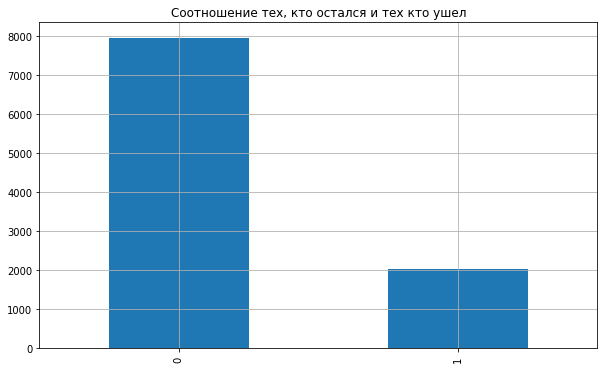

In [103]:
# Рисую гистограмму значений оттока и оставшихся клиентов
df['Exited'].value_counts().plot(kind='bar',grid=True,figsize=(10,6),title='Соотношение тех, кто остался и тех кто ушел')

Соотношение оттока и тех кто остался 1:4. Вывод: такое соотношение говорит, что присутствует дисбаланс в данных.

**One hot encoder**

Избавляемся от категориальных признаков методом One hot encoder

In [104]:
df_ohe=pd.get_dummies(df,drop_first=True) # вызываем метод get_dummies для избавления от категориальных признаков

In [105]:
target=df_ohe['Exited'] # Целевой признак
features=df_ohe.drop(['Exited'],axis=1) # Признаки

In [106]:
#Разбиваем данные после OHE на шесть выборок:
#train_features, valid_features, features_test, train_target, valid_target, target_test 

train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.4, random_state=1234)
features_test, valid_features, target_test, valid_target = train_test_split(valid_features, valid_target, test_size=0.5, random_state=1234)

print('Обучающая выборка:',train_features.shape)
print(train_target.shape)
print('Валидационная выборка:',valid_features.shape)
print(valid_target.shape)
print('Тестовая выборка:',features_test.shape)
print(target_test.shape)

Обучающая выборка: (6000, 10)
(6000,)
Валидационная выборка: (2000, 10)
(2000,)
Тестовая выборка: (2000, 10)
(2000,)


In [154]:
pd.options.mode.chained_assignment = None
# Стандартизируем тестовую и валидную выборку, т.к есть значения и маленькие и очень большие. 
numeric=['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember']
scaler=StandardScaler()
scaler.fit(train_features[numeric])
train_features[numeric]=scaler.transform(train_features[numeric])
valid_features[numeric]=scaler.transform(valid_features[numeric])

**Строю модель без учета баланса**



**Обучение с помощью модели Дерево решения**

In [13]:
# Циклом ищем лучший гиперпараметр max_depth
best_model_tree = None
best_est = 0
best_f1_score = 0

for depth in range(1, 50, 1):
    model_tree=DecisionTreeClassifier(max_depth=depth, random_state=1234).fit(train_features,train_target)
    prediction=model_tree.predict(valid_features)
    ff1_score = f1_score(valid_target, prediction)
    if ff1_score > best_f1_score:
        best_model_tree = model_tree 
        best_est = depth 
        best_f1_score = ff1_score
            
print('max_depth:', best_est,'F1:', best_f1_score)

max_depth: 7 F1: 0.5733512786002692


**Обучение с помощью модели Случайный лес**

In [14]:
# Циклом ищем лучший гиперпараметр max_depth и гиперпараметр n_estimators (количество деревьев)
best_model_forest = None
best_est = 0
best_f1_score = 0
best_n_estimators = 0

for depth in range(1, 20, 1):
    for estim in range(1, 51, 1):
        model_forest = RandomForestClassifier(max_depth = depth, n_estimators = estim, random_state = 1234)
        model_forest.fit(train_features, train_target)
        prediction = model_forest.predict(valid_features)
        ff1_score = f1_score(valid_target, prediction)
        if ff1_score > best_f1_score:
            best_model_forest = model_forest 
            best_est = depth 
            best_f1_score = ff1_score
            best_n_estimators = estim
            
print('max_depth:', best_est,'F1:', best_f1_score, 'n_estimators:', best_n_estimators)

max_depth: 16 F1: 0.6005509641873279 n_estimators: 27


**Обучение с помощью модели Логистической регрессии**

In [15]:
model_logistic=LogisticRegression().fit(train_features,train_target)
prediction=model_logistic.predict(valid_features)
print('F1:',f1_score(valid_target,prediction))

F1: 0.3395585738539898


**Исследование метрика AUC-ROC**

In [16]:
probabilities_tree = best_model_tree.predict_proba(valid_features)
probabilities_one_valid_tree = probabilities_tree[:,1]
fpr_tree, tpr_tree, thresholds = roc_curve(valid_target, probabilities_one_valid_tree)

In [17]:
auc_roc_tree = roc_auc_score(valid_target, probabilities_one_valid_tree)

In [18]:
auc_roc_tree

0.813745204507945

In [19]:
probabilities_forest = best_model_forest.predict_proba(valid_features)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest, tpr_forest, thresholds = roc_curve(valid_target, probabilities_one_valid_forest)

In [20]:
auc_roc_forest = roc_auc_score(valid_target, probabilities_one_valid_forest)

In [21]:
auc_roc_forest

0.8347220621090097

In [22]:
probabilities_reg = model_logistic.predict_proba(valid_features)
probabilities_one_valid_reg = probabilities_reg[:,1]
fpr_log, tpr_log, thresholds = roc_curve(valid_target, probabilities_one_valid_reg)

In [23]:
auc_roc_reg = roc_auc_score(valid_target, probabilities_one_valid_reg)

In [24]:
auc_roc_reg

0.7652255504692249

<Figure size 432x288 with 0 Axes>

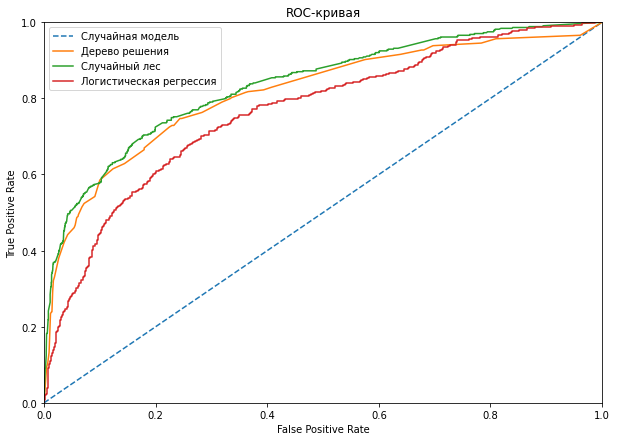

In [25]:
plt.figure()

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_tree, tpr_tree)
plt.plot(fpr_forest, tpr_forest)
plt.plot(fpr_log, tpr_log)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель', 'Дерево решения', 'Случайный лес', 'Логистическая регрессия'),
           loc= 'upper left') 
plt.show()

**Общий вывод:**

Рассматривая данные с дисбалансом (но с данными переведенныи в категориальные и стандартизированные), по трем моделям можно сделать вывод, что лучший результат показала модель Случайный лес. При лучшем значении max_depth=16 и n_estimators=27, мы имеем F1 меру =0,60 на валидной выборке.

## Борьба с дисбалансом

**Воспользуемся функцией Upsampling и увеличим количество клиентов оттока (target == 1)**

In [26]:
## Функция Upsampling
def upsampling (features, target, repeat):
    #Разделяем выборку по значениям целевой функции
    target_one = target[target == 1]
    target_null = target[target == 0] 
    features_one = features[target == 1]
    features_null = features[target == 0]
    
    #Увеличиваем и соединяем обратно
    upsampling_features = pd.concat([features_null] + [features_one] * repeat)
    upsampling_target = pd.concat([target_null] + [target_one] * repeat)
    
    # Перемешиваем
    upsampling_features, upsampling_target = shuffle(upsampling_features, upsampling_target, random_state=1234)
    
    return upsampling_features, upsampling_target

In [27]:
features_balance_up, target_balance_up = upsampling(train_features, train_target, 4)

In [28]:
features_valid_balance_up, target_valid_balance_up = upsampling(valid_features, valid_target, 4)

In [29]:
%%time
# Циклом ищем лучший гиперпораметр max_depth
best_model_tree_1 = None
best_est = 0
best_f1_score = 0

for depth in range(1, 50, 1):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=1234)
    model_tree.fit(features_balance_up, target_balance_up)
    prediction = model_tree.predict(features_valid_balance_up)
    ff1_score = f1_score(target_valid_balance_up, prediction)
    if ff1_score > best_f1_score:
        best_model_tree_1 = model_tree
        best_est = depth 
        best_f1_score = ff1_score
            
print('max_depth:', best_est,'F1:', best_f1_score)

max_depth: 5 F1: 0.7613469985358713
CPU times: user 1.91 s, sys: 3.96 ms, total: 1.91 s
Wall time: 1.94 s


In [123]:
%%time
# Циклом ищем лучший гиперпораметр max_depth
best_model_tree_2 = None
best_est = 0
best_f1_score = 0

for depth in range(1, 50, 1):
    model_tree = DecisionTreeClassifier(class_weight='balanced', max_depth=depth, random_state=1234)
    model_tree.fit(features_balance_up, target_balance_up)
    prediction = model_tree.predict(features_valid_balance_up)
    ff1_score = f1_score(target_valid_balance_up, prediction)
    if ff1_score > best_f1_score:
        best_model_tree_2 = model_tree 
        best_est = depth 
        best_f1_score = ff1_score
            
print('max_depth:', best_est,'F1:', best_f1_score)

max_depth: 4 F1: 0.42653061224489797
CPU times: user 1.44 s, sys: 8 µs, total: 1.44 s
Wall time: 1.44 s


In [31]:
%%time
# Циклом ищем лучший гиперпораметр max_depth и гиперпораметр n_estimators (количество деревьев)
best_model_forest_1 = None
best_est = 0
best_f1_score = 0
best_n_estimators = 0

for depth in range(1, 20, 1):
    for estim in range(1, 51, 1):
        model_forest = RandomForestClassifier( max_depth = depth, n_estimators = estim, random_state = 1234)
        model_forest.fit(features_balance_up, target_balance_up)
        prediction = model_forest.predict(features_valid_balance_up)
        ff1_score = f1_score(target_valid_balance_up, prediction)
        if ff1_score > best_f1_score:
            best_model_forest_1 = model_forest 
            best_est = depth 
            best_f1_score = ff1_score
            best_n_estimators = estim
            
print('max_depth:', best_est,'F1:', best_f1_score, 'n_estimators:', best_n_estimators)

max_depth: 8 F1: 0.7736424649176327 n_estimators: 50
CPU times: user 4min 4s, sys: 699 ms, total: 4min 5s
Wall time: 4min 7s


In [32]:
%%time
# Циклом ищем лучший гиперпораметр max_depth и гиперпораметр n_estimators (количество деревьев)
best_model_forest_2 = None
best_est = 0
best_f1_score = 0
best_n_estimators = 0

for depth in range(1, 20, 1):
    for estim in range(1, 51, 1):
        model_forest = RandomForestClassifier(class_weight='balanced', max_depth = depth, n_estimators = estim, random_state = 1234)
        model_forest.fit(features_balance_up, target_balance_up)
        prediction = model_forest.predict(features_valid_balance_up)
        ff1_score = f1_score(target_valid_balance_up, prediction)
        if ff1_score > best_f1_score:
            best_model_forest_2 = model_forest 
            best_est = depth 
            best_f1_score = ff1_score
            best_n_estimators = estim
            
print('max_depth:', best_est,'F1:', best_f1_score, 'n_estimators:', best_n_estimators)

max_depth: 8 F1: 0.7781528076096962 n_estimators: 18
CPU times: user 4min 4s, sys: 768 ms, total: 4min 5s
Wall time: 4min 6s


In [33]:
%%time
model_logistic_1=LogisticRegression(solver='liblinear').fit(features_balance_up,target_balance_up)
prediction=model_logistic_1.predict(features_valid_balance_up)
print('F1:',f1_score(target_valid_balance_up,prediction))

F1: 0.713904536021346
CPU times: user 90.8 ms, sys: 80.2 ms, total: 171 ms
Wall time: 179 ms


In [34]:
%%time
model_logistic_2=LogisticRegression(class_weight='balanced',solver='liblinear').fit(features_balance_up,target_balance_up)
prediction=model_logistic_2.predict(features_valid_balance_up)
print('F1:',f1_score(target_valid_balance_up,prediction))

F1: 0.7142857142857143
CPU times: user 60.1 ms, sys: 60 ms, total: 120 ms
Wall time: 98.4 ms


**Воспользуемся функцией Downsampling и уберем часть оставшихся клиентов (target==0)**

In [35]:
def downsampling(features,target,fraction):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    downsampling_features=pd.concat([features_null.sample(frac=fraction, random_state=1234)]+[features_one])
    downsampling_target=pd.concat([target_null.sample(frac=fraction, random_state=1234)]+[target_one])
    
    downsampling_features,downsampling_target=shuffle(downsampling_features,downsampling_target,random_state=1234)
    return downsampling_features,downsampling_target

In [36]:
features_balance_up,target_balance_up=downsampling(features,target,0.25)

In [37]:
features_valid_balance_up2, target_valid_balance_up2 =downsampling(valid_features, valid_target,0.25)

**После балансирования данных. Обучение Дерево решения**

In [114]:
%%time
# Циклом ищем лучший гиперпораметр max_depth
best_model_tree_3 = None
best_est = 0
best_f1_score = 0

for depth in range(1, 50, 1):
    model_tree = DecisionTreeClassifier( max_depth=depth, random_state=1234)
    model_tree.fit(features_balance_up, target_balance_up)
    prediction = model_tree.predict(features_valid_balance_up2)
    ff1_score = f1_score(target_valid_balance_up2, prediction)
    if ff1_score > best_f1_score:
        best_model_tree_3 = model_tree 
        best_est = depth 
        best_f1_score = ff1_score
            
print('max_depth:', best_est,'F1:', best_f1_score)

max_depth: 4 F1: 0.5726027397260275
CPU times: user 1.43 s, sys: 3.97 ms, total: 1.44 s
Wall time: 1.44 s


In [39]:
%%time
# Циклом ищем лучший гиперпораметр max_depth
best_model_tree_4 = None
best_est = 0
best_f1_score = 0

for depth in range(1, 50, 1):
    model_tree = DecisionTreeClassifier(class_weight='balanced', max_depth=depth, random_state=1234)
    model_tree.fit(features_balance_up, target_balance_up)
    prediction = model_tree.predict(features_valid_balance_up2)
    ff1_score = f1_score(target_valid_balance_up2, prediction)
    if ff1_score > best_f1_score:
        best_model_tree_4 = model_tree 
        best_est = depth 
        best_f1_score = ff1_score
            
print('max_depth:', best_est,'F1:', best_f1_score)

max_depth: 4 F1: 0.5726027397260275
CPU times: user 1.44 s, sys: 3.97 ms, total: 1.44 s
Wall time: 1.46 s


**После балансирования данных. Обучение Случайный лес**

In [119]:
%%time
# Циклом ищем лучший гиперпораметр max_depth и гиперпораметр n_estimators (количество деревьев)
best_model_forest_3 = None
best_est = 0
best_f1_score = 0
best_n_estimators = 0

for depth in range(1, 20, 1):
    for estim in range(1, 51, 1):
        model_forest = RandomForestClassifier(max_depth = depth, n_estimators = estim, random_state = 1234)
        model_forest.fit(features_balance_up, target_balance_up)
        prediction = model_forest.predict(features_valid_balance_up2)
        ff1_score = f1_score(target_valid_balance_up2, prediction)
        if ff1_score > best_f1_score:
            best_model_forest_3 = model_forest 
            best_est = depth 
            best_f1_score = ff1_score
            best_n_estimators = estim
            
print('max_depth:', best_est,'F1:', best_f1_score, 'n_estimators:', best_n_estimators)

max_depth: 6 F1: 0.451948051948052 n_estimators: 5
CPU times: user 2min 17s, sys: 468 ms, total: 2min 18s
Wall time: 2min 18s


In [41]:
%%time
# Циклом ищем лучший гиперпораметр max_depth и гиперпораметр n_estimators (количество деревьев)
best_model_forest_4 = None
best_est = 0
best_f1_score = 0
best_n_estimators = 0

for depth in range(1, 20, 1):
    for estim in range(1, 51, 1):
        model_forest = RandomForestClassifier(class_weight='balanced', max_depth = depth, n_estimators = estim, random_state = 1234)
        model_forest.fit(features_balance_up, target_balance_up)
        prediction = model_forest.predict(features_valid_balance_up2)
        ff1_score = f1_score(target_valid_balance_up2, prediction)
        if ff1_score > best_f1_score:
            best_model_forest_4 = model_forest 
            best_est = depth 
            best_f1_score = ff1_score
            best_n_estimators = estim
            
print('max_depth:', best_est,'F1:', best_f1_score, 'n_estimators:', best_n_estimators)

max_depth: 6 F1: 0.6991720331186754 n_estimators: 3
CPU times: user 2min 25s, sys: 572 ms, total: 2min 26s
Wall time: 2min 26s


**После балансирования данных. Обучение Логистической регрессии**

In [42]:
%%time
model_logistic_3=LogisticRegression(solver='liblinear').fit(features_valid_balance_up2,target_valid_balance_up2)
prediction=model_logistic_3.predict(features_valid_balance_up2)
print('F1:',f1_score(target_valid_balance_up2,prediction))

F1: 0.7175398633257403
CPU times: user 9.19 ms, sys: 3.99 ms, total: 13.2 ms
Wall time: 11 ms


In [43]:
%%time
model_logistic_4=LogisticRegression(class_weight='balanced',solver='liblinear').fit(features_valid_balance_up2,target_valid_balance_up2)
prediction=model_logistic_4.predict(features_valid_balance_up2)
print('F1:',f1_score(target_valid_balance_up2,prediction))

F1: 0.7011764705882353
CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 9.44 ms


**Исследование метрика AUC-ROC после борьбы с дисбалансом**

In [44]:
probabilities_tree = best_model_tree_1.predict_proba(features_valid_balance_up)
probabilities_one_valid_tree = probabilities_tree[:,1]
fpr_tree_1, tpr_tree_1, thresholds = roc_curve(target_valid_balance_up, probabilities_one_valid_tree)

auc_roc_tree = roc_auc_score(target_valid_balance_up, probabilities_one_valid_tree)
auc_roc_tree

0.8398717894463422

In [45]:
probabilities_tree = best_model_tree_2.predict_proba(features_valid_balance_up)
probabilities_one_valid_tree = probabilities_tree[:,1]
fpr_tree_2, tpr_tree_2, thresholds = roc_curve(target_valid_balance_up, probabilities_one_valid_tree)

auc_roc_tree = roc_auc_score(target_valid_balance_up, probabilities_one_valid_tree)
auc_roc_tree

0.8398717894463422

In [46]:
probabilities_tree = best_model_tree_3.predict_proba(features_valid_balance_up2)
probabilities_one_valid_tree = probabilities_tree[:,1]
fpr_tree_3, tpr_tree_3, thresholds = roc_curve(target_valid_balance_up2, probabilities_one_valid_tree)

auc_roc_tree = roc_auc_score(target_valid_balance_up2, probabilities_one_valid_tree)
auc_roc_tree

0.6470182816424275

In [47]:
probabilities_tree = best_model_tree_4.predict_proba(features_valid_balance_up2)
probabilities_one_valid_tree = probabilities_tree[:,1]
fpr_tree_4, tpr_tree_4, thresholds = roc_curve(target_valid_balance_up2, probabilities_one_valid_tree)

auc_roc_tree = roc_auc_score(target_valid_balance_up2, probabilities_one_valid_tree)
auc_roc_tree

0.6470182816424275

In [48]:
probabilities_forest = best_model_forest_1.predict_proba(features_valid_balance_up)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest_1, tpr_forest_1, thresholds = roc_curve(target_valid_balance_up, probabilities_one_valid_forest)

auc_roc_forest = roc_auc_score(target_valid_balance_up, probabilities_one_valid_forest)
auc_roc_forest

0.8529044374626976

In [49]:
probabilities_forest = best_model_forest_2.predict_proba(features_valid_balance_up)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest_2, tpr_forest_2, thresholds = roc_curve(target_valid_balance_up, probabilities_one_valid_forest)

auc_roc_forest = roc_auc_score(target_valid_balance_up, probabilities_one_valid_forest)
auc_roc_forest

0.8542469563491659

In [50]:
probabilities_forest = best_model_forest_3.predict_proba(features_valid_balance_up2)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest_3, tpr_forest_3, thresholds = roc_curve(target_valid_balance_up2, probabilities_one_valid_forest)

auc_roc_forest = roc_auc_score(target_valid_balance_up2, probabilities_one_valid_forest)
auc_roc_forest

0.6457683546521815

In [51]:
probabilities_forest = best_model_forest_4.predict_proba(features_valid_balance_up2)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest_4, tpr_forest_4, thresholds = roc_curve(target_valid_balance_up2, probabilities_one_valid_forest)

auc_roc_forest = roc_auc_score(target_valid_balance_up2, probabilities_one_valid_forest)
auc_roc_forest

0.6624613048303254

In [52]:
probabilities_reg = model_logistic_1.predict_proba(features_valid_balance_up)
probabilities_one_valid_reg = probabilities_reg[:,1]
fpr_log_1, tpr_log_1, thresholds = roc_curve(target_valid_balance_up, probabilities_one_valid_reg)

auc_roc_reg = roc_auc_score(target_valid_balance_up, probabilities_one_valid_reg)
auc_roc_reg

0.7666775138301334

In [53]:
probabilities_reg = model_logistic_2.predict_proba(features_valid_balance_up)
probabilities_one_valid_reg = probabilities_reg[:,1]
fpr_log_2, tpr_log_2, thresholds = roc_curve(target_valid_balance_up, probabilities_one_valid_reg)

auc_roc_reg = roc_auc_score(target_valid_balance_up, probabilities_one_valid_reg)
auc_roc_reg

0.7666643804932005

In [54]:
probabilities_reg = model_logistic_3.predict_proba(features_valid_balance_up2)
probabilities_one_valid_reg = probabilities_reg[:,1]
fpr_log_3, tpr_log_3, thresholds = roc_curve(target_valid_balance_up2, probabilities_one_valid_reg)

auc_roc_reg = roc_auc_score(target_valid_balance_up2, probabilities_one_valid_reg)
auc_roc_reg

0.7621166987909584

In [55]:
probabilities_reg = model_logistic_4.predict_proba(features_valid_balance_up2)
probabilities_one_valid_reg = probabilities_reg[:,1]
fpr_log_4, tpr_log_4, thresholds = roc_curve(target_valid_balance_up2, probabilities_one_valid_reg)

auc_roc_reg = roc_auc_score(target_valid_balance_up2, probabilities_one_valid_reg)
auc_roc_reg

0.7620232463057064

<Figure size 432x288 with 0 Axes>

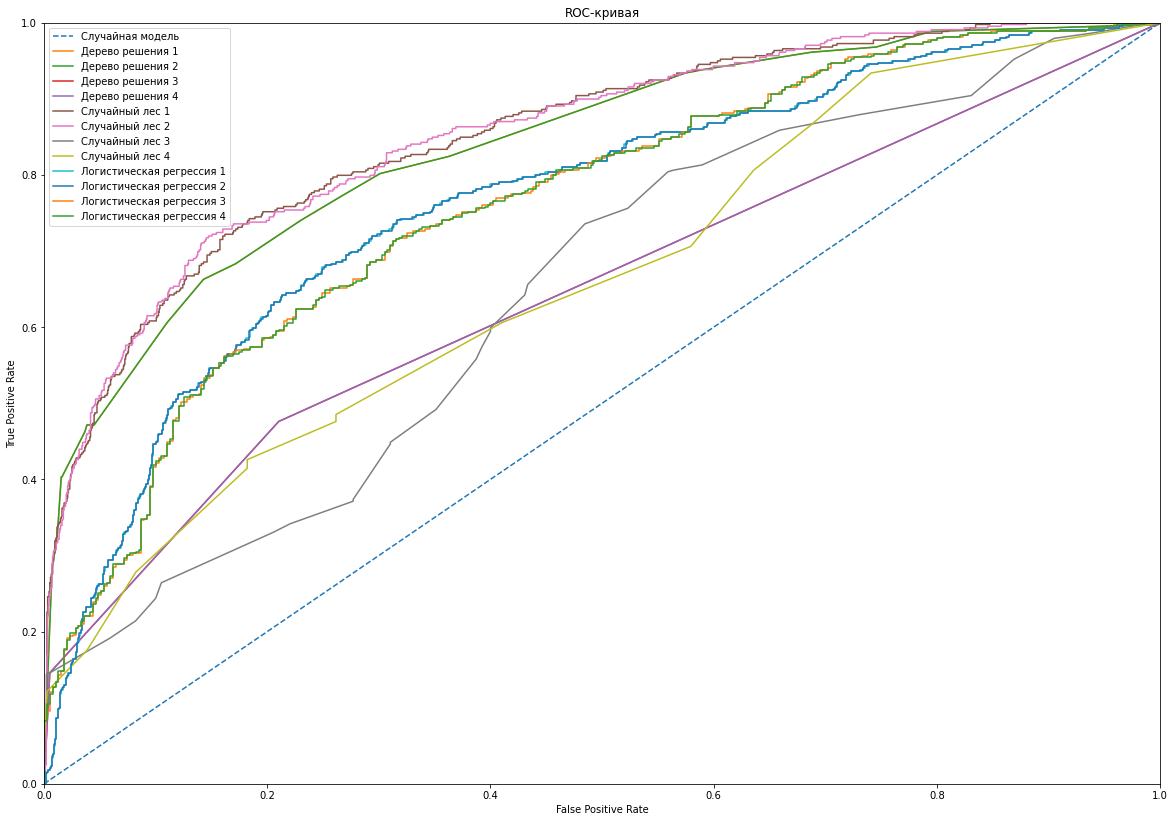

In [56]:
plt.figure()

plt.figure(figsize=(20, 14))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_tree_1, tpr_tree_1)
plt.plot(fpr_tree_2, tpr_tree_2)
plt.plot(fpr_tree_3, tpr_tree_3)
plt.plot(fpr_tree_4, tpr_tree_4)

plt.plot(fpr_forest_1, tpr_forest_1)
plt.plot(fpr_forest_2, tpr_forest_2)
plt.plot(fpr_forest_3, tpr_forest_3)
plt.plot(fpr_forest_4, tpr_forest_4)

plt.plot(fpr_log_1, tpr_log_1)
plt.plot(fpr_log_2, tpr_log_2)
plt.plot(fpr_log_3, tpr_log_3)
plt.plot(fpr_log_4, tpr_log_4)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель', 
            'Дерево решения 1', 'Дерево решения 2', 'Дерево решения 3', 'Дерево решения 4',
            'Случайный лес 1', 'Случайный лес 2', 'Случайный лес 3', 'Случайный лес 4', 
            'Логистическая регрессия 1', 'Логистическая регрессия 2', 'Логистическая регрессия 3', 'Логистическая регрессия 4'),
           loc= 'upper left') 
plt.show()

**Общий вывод:**

Значение площади под кривой. На сколько нашb моделb отличается от случайной.
Лучший результат показала модель best_model_forest_1 без балансировки данных обученная на данных отбалансированных функцией Upsampling. F1 составила 0.77, при глубине 8 и количестве деревьев 50

А среди данных маштабированных функцией Downsampling лучшей моделью стала best_model_forest_3. F1 составила 0.70, при глубине 4 и количестве деревьев 12

Будем использовать их.

## Тестирование модели

In [57]:
# features_test_balance_up, target_test_balance_up = upsampling(features_test, target_test, 4)

In [58]:
best_model_tree_1
prediction = best_model_forest_1.predict(features_test)
print('F1', f1_score(target_test, prediction))

F1 0.16764705882352943


In [59]:
probabilities_forest = best_model_forest_1.predict_proba(features_test)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest, tpr_forest, thresholds = roc_curve(target_test, probabilities_one_valid_forest)

In [60]:
auc_roc_forest = roc_auc_score(target_test, probabilities_one_valid_forest)

In [61]:
auc_roc_forest

0.35210129310344823

<Figure size 432x288 with 0 Axes>

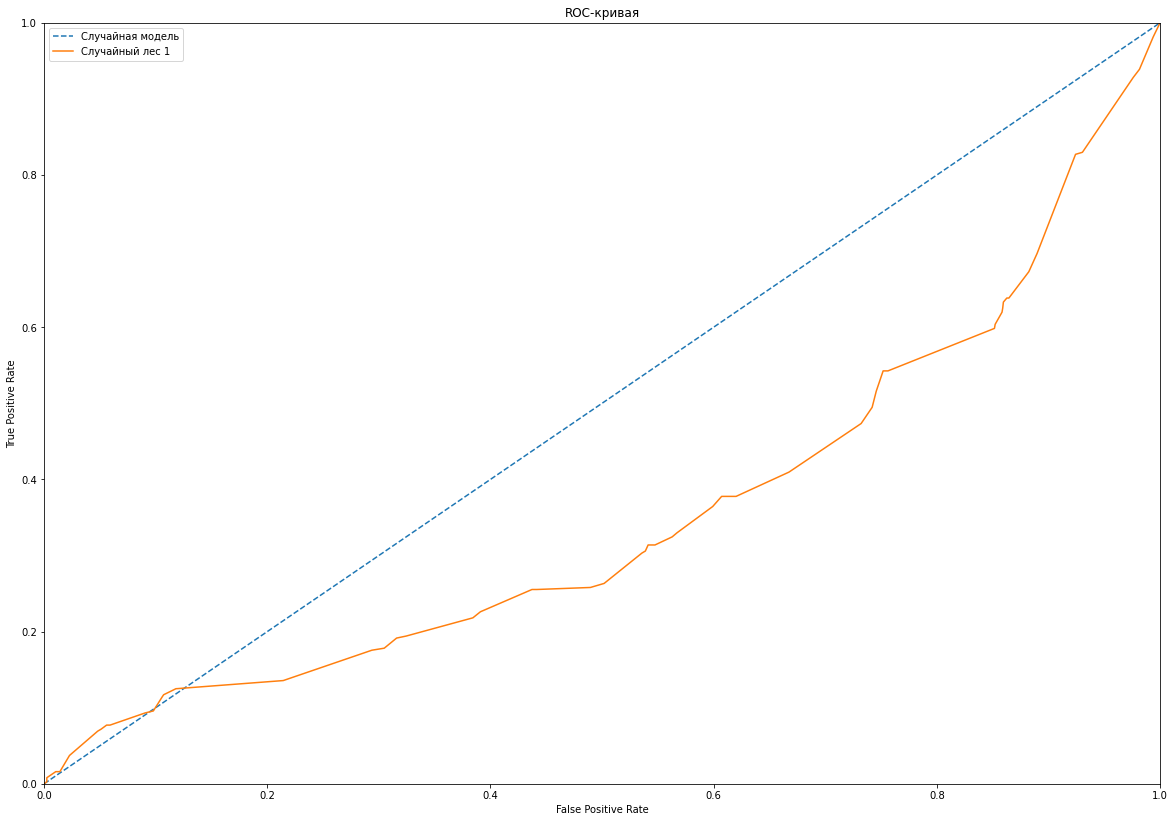

In [62]:
plt.figure()

plt.figure(figsize=(20, 14))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot(fpr_forest, tpr_forest)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель', 'Случайный лес 1'),
           loc= 'upper left') 
plt.show()

**протестируем модель best_model_tree_3**

In [158]:
best_model_tree_3
prediction = best_model_forest_3.predict(features_test)
print('F1', f1_score(target_test, prediction))

F1 0.5970178926441353


In [136]:
probabilities_forest = best_model_forest_3.predict_proba(features_test)
probabilities_one_valid_forest = probabilities_forest[:,1]
fpr_forest, tpr_forest, thresholds = roc_curve(target_test, probabilities_one_valid_forest)

auc_roc_forest = roc_auc_score(target_test, probabilities_one_valid_forest)
auc_roc_forest

0.8594446009328163

<Figure size 432x288 with 0 Axes>

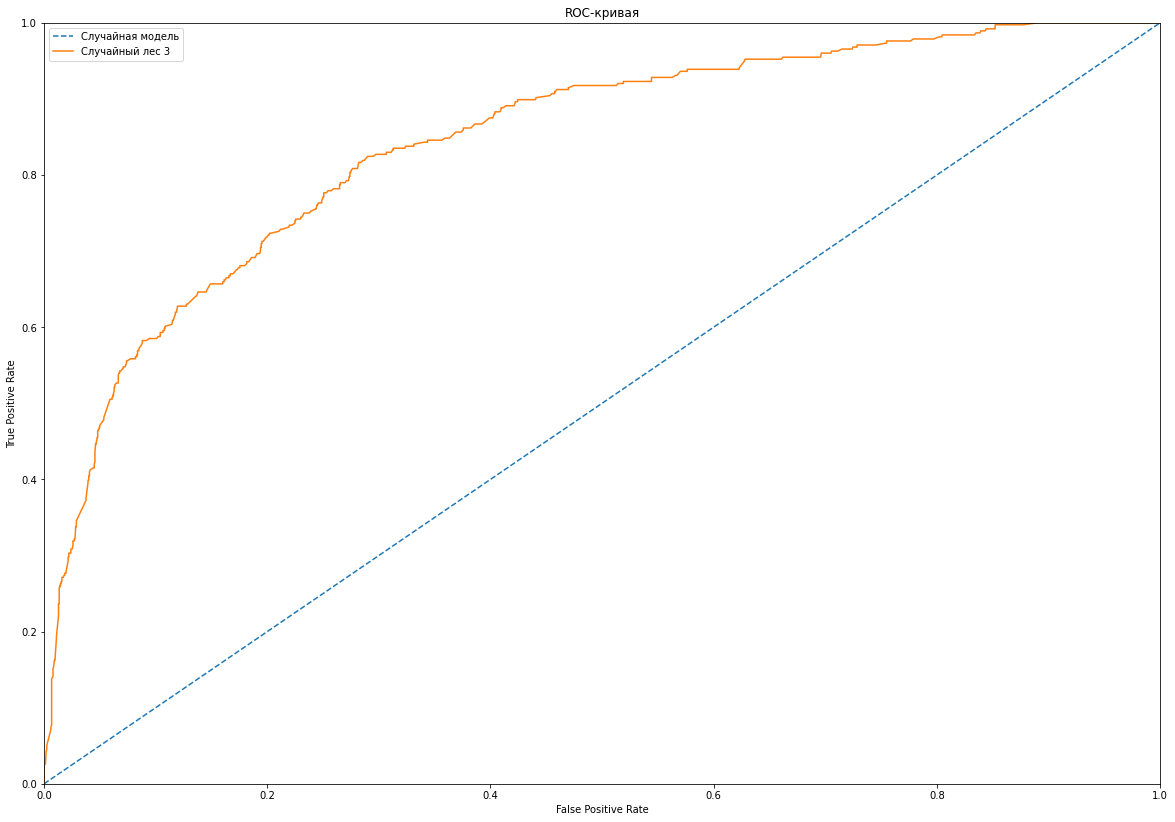

In [65]:
plt.figure()

plt.figure(figsize=(20, 14))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot(fpr_forest, tpr_forest)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель', 'Случайный лес 3'),
           loc= 'upper left') 
plt.show()

**Общий вывод:**
Тестование показало, что модель best_model_tree_3, обученная на данных отмаштабированных в меньшую сторону функцией Downsampling, выдает предсказания намного более точные нежели можель best_model_tree_1. 

В тоже время, необходимо отметить, что точность предсказаний упала, относительно результатов показанных на валидационной выборке.